In [0]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import datetime
from copy import copy
FIGSIZE=(20,10)

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.75, rc={"lines.linewidth": 2.})

In [0]:
# data preparation and preprocessing
data = pd.read_csv('venezia_corrected.csv')
data['date'] = pd.to_datetime(data['date'])

In [0]:
ts_data = data.set_index('date')
ts = ts_data['level']

### Plot data

In [0]:
from warnings import filterwarnings
filterwarnings('ignore')

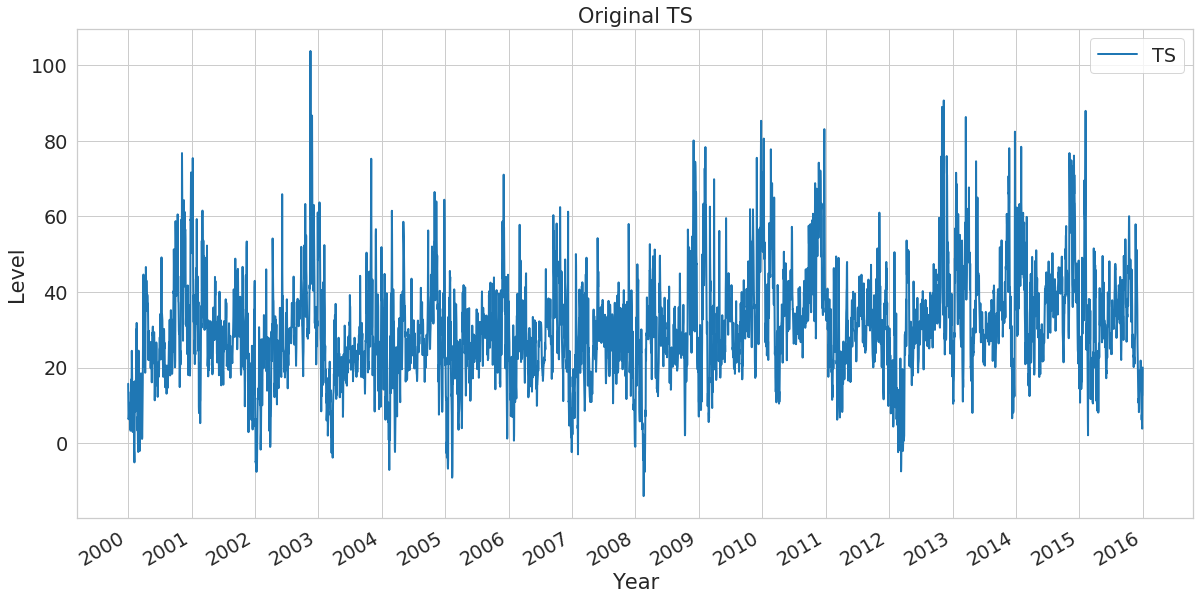

In [7]:
import matplotlib.dates as mdates
import datetime

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(ts, label='TS')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)


plt.ylabel("Level")
plt.xlabel("Year")
plt.title("Original TS")
fig.autofmt_xdate()
plt.legend();

### Splitting the data

In [0]:
# we will make the prediction for last 4 months of observations
idx = 120
train = ts.values[:-idx, np.newaxis]
test = ts.values[-idx:, np.newaxis]

# scaling our data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)

In [0]:
# constucting the input specific for RNN
# as soon as nn needs fixed length input, we need to specify the time interval used for prediction
# we will use past 7 month(or 210 days) data for making the prediction

timelen = 7 * 30
X_train, y_train = [],[]
for i in range(timelen, train.shape[0]):
    X_train.append(train_scaled[i-timelen:i])
    y_train.append(train_scaled[i])
    
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1,1)

In [0]:
# constructing the test set
all_values = np.concatenate([train, test], axis=0)

start_test_ind = len(all_values) - len(test) - timelen
test_values = scaler.transform(all_values[start_test_ind:])

X_test = []
for i in range(timelen, test_values.shape[0]):
    X_test.append(test_values[i-timelen:i])
    
X_test = np.array(X_test)
y_test = np.copy(test)

In [15]:
print('Train shapes: {}, {}'.format(X_train.shape, y_train.shape))
print('Test shapes: {}, {}'.format(X_test.shape, y_test.shape))

Train shapes: (5515, 210, 1), (5515, 1)
Test shapes: (120, 210, 1), (120, 1)


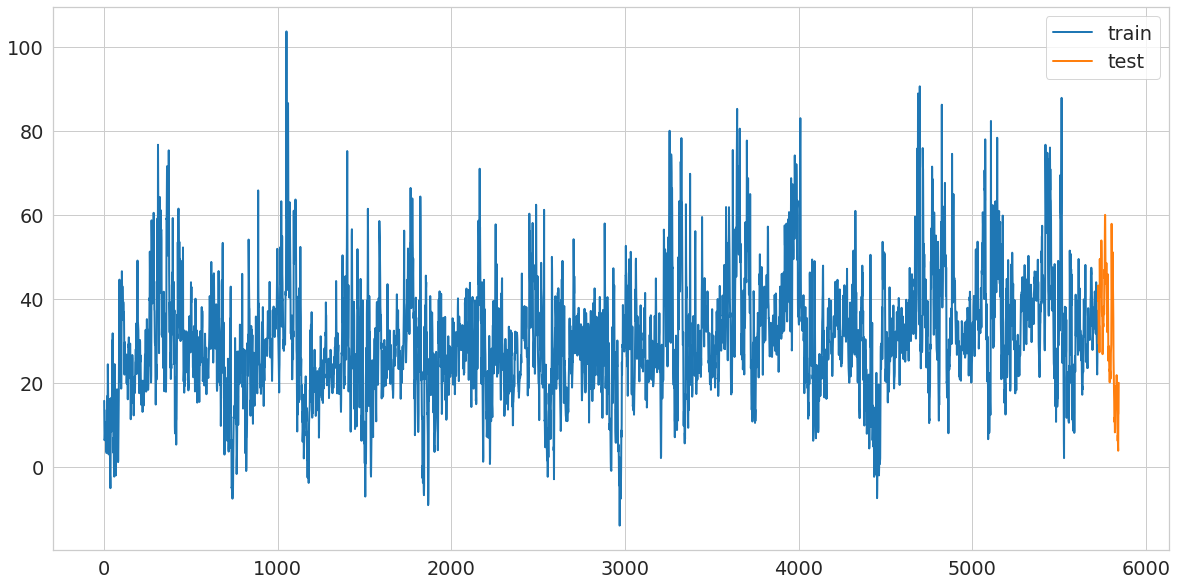

In [18]:
plt.subplots(figsize=FIGSIZE)
plt.plot(train, label='train')
plt.plot(pd.Series(np.squeeze(test), index=range(train.shape[0], train.shape[0]+len(test))), label='test')
plt.legend();

### Building the model

In [19]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Dropout, Input, Flatten
import keras.callbacks

Using TensorFlow backend.


In [0]:
input_layer = Input(shape=(X_train.shape[1], 1))
x = LSTM(units = 60, return_sequences = True)(input_layer)
x = Dropout(.2)(x)

x = LSTM(units = 60, return_sequences = True)(x)
x = Dropout(.2)(x)

x = LSTM(units = 60)(x)
x = Dropout(.2)(x)

out = Dense(1)(x)

model = Model(inputs=input_layer, outputs=out)

In [29]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 210, 1)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 210, 60)           14880     
_________________________________________________________________
dropout_10 (Dropout)         (None, 210, 60)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 210, 60)           29040     
_________________________________________________________________
dropout_11 (Dropout)         (None, 210, 60)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60)                0   

In [0]:
# we have 75k params to train

In [31]:
# compile model using Adam optimizer and MSE loss
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
5515/5515 [==============================] - 151s 27ms/step - loss: 0.0135
Epoch 2/50
5515/5515 [==============================] - 148s 27ms/step - loss: 0.0084
Epoch 3/50
5515/5515 [==============================] - 149s 27ms/step - loss: 0.0073
Epoch 4/50
5515/5515 [==============================] - 148s 27ms/step - loss: 0.0064
Epoch 5/50
5515/5515 [==============================] - 149s 27ms/step - loss: 0.0054
Epoch 6/50
5515/5515 [==============================] - 148s 27ms/step - loss: 0.0048
Epoch 7/50
5515/5515 [==============================] - 149s 27ms/step - loss: 0.0044
Epoch 8/50
5515/5515 [==============================] - 149s 27ms/step - loss: 0.0043
Epoch 9/50
5515/5515 [==============================] - 149s 27ms/step - loss: 0.0040
Epoch 10/50
5515/5515 [==============================] - 148s 27ms/step - loss: 0.0039
Epoch 11/50
5515/5515 [==============================] - 149s 27ms/step - loss: 0.0039
Epoch 12/50
5515/5515 [=============================

KeyboardInterrupt: ignored

In [0]:
# make the prediction and inverse transformation of prediction
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)

In [0]:
# we will plot only last 3k observations, so it would be more interpretable
train_shorten = np.copy(train[-1000:])
test_plot =  pd.Series(np.squeeze(test), index=range(train_shorten.shape[0], train_shorten.shape[0]+len(test)))
pred_plot =  pd.Series(np.squeeze(y_pred_inv), index=range(train_shorten.shape[0], train_shorten.shape[0]+len(y_pred_inv)))

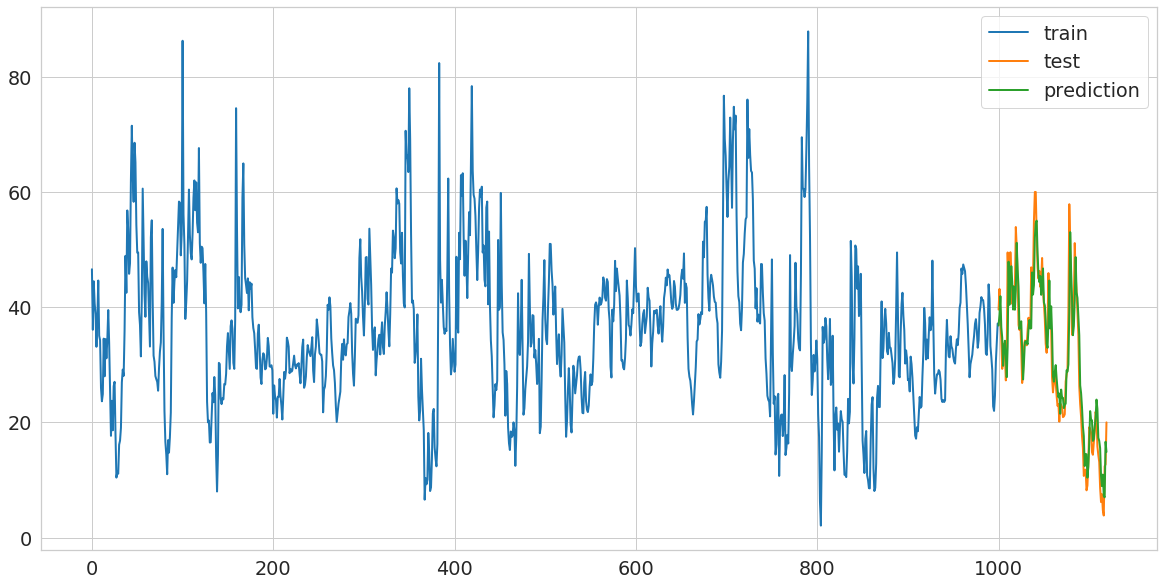

In [44]:
plt.subplots(figsize=FIGSIZE)
plt.title("Venice water level prediction")
plt.plot(train_shorten, label='train')
plt.plot(test_plot, label='test')
plt.plot(pred_plot, label='prediction')
plt.legend();

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [41]:
print("Results: \nRMSE: {}\nMAE: {}\nMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_pred_inv)),
                                                     mean_absolute_error(y_test, y_pred_inv),
                                                     mean_squared_error(y_test, y_pred_inv)))

Results: 
RMSE: 4.734272845604273
MAE: 3.611528556876712
MSE: 22.413339376625977
